In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from tqdm import tqdm 
import datetime
from sympy import Integer

In [154]:
factor_path = "/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/factor/"

futureCodeList = ['JBF', 'QWF', 'HCF', 'DBF', 'EHF', 'IPF', 'IIF', 'QXF', 'PEF', 'NAF']
stockCodeList = ['3443', '2388', '2498', '2610', '1319', '3035', '3006', '2615', '5425', '3105']

data_clean_path = '/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/dataCleaned/'

In [155]:
futureCode = futureCodeList[0]
stockCode = stockCodeList[0]

In [156]:
stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']

Benchmark

In [157]:
pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [158]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL_bench = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 1:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnL_bench = np.append(PnL_bench, test[test['pnl'] != 0]['pnl'] + PnL_bench[-1])

100%|██████████| 30/30 [02:26<00:00,  4.90s/it]


In [159]:
PnL_bench

array([     0,   1000,   1500,   2500,   3000,   3500,   4500,   5000,
         5500,   6000,   7000,   8000,   8500,   9000,  10000,  11000,
        12000,  12500,  13000,  14000,  15000,  16000,  16500,  17000,
        17500,  18000,  18500,  19500,  20500,  21000,  22000,  23000,
        23500,  24500,  25500,  26500,  27500,  28500,  29500,  30000,
        30500,  31500,  32500,  33000,  33500,  34000,  35500,  36500,
        37000,  37500,  38500,  39500,  40000,  41000,  41500,  42500,
        43500,  44500,  45000,  45500,  46500,  47500,  47500,  48000,
        49000,  49500,  50500,  51000,  51500,  52500,  53500,  54500,
        55500,  56000,  56500,  57000,  57500,  58500,  59500,  60000,
        61000,  61500,  62000,  62000,  63000,  64000,  65000,  66000,
        66500,  67500,  68500,  69500,  70000,  70500,  71500,  72500,
        73500,  74500,  75000,  76000,  77000,  77500,  78000,  79000,
        80000,  80500,  81500,  82000,  82500,  83000,  83500,  84000,
      

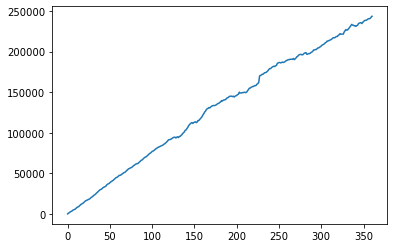

In [160]:
plt.plot(PnL_bench)

lead lag

In [161]:
pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [162]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL_ll = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]
    today_stock = stock[test_start_time & test_end_time]
    today_future = future[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 1:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] > today_stock[tick_idx : tick_idx + 1]['SP1'][0]) and ((tick_idx + lead) < tick_idx + 3):
                        lead = lead + 1
                    # if np.log(today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0]) - np.log(today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]) <= lower:
                    test.at[test.index[tick_idx + lead], 'signal'] = 1
                    test.at[test.index[tick_idx + lead], 'cap'] = today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] * 2 - today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] < today_stock[tick_idx : tick_idx + 1]['BP1'][0]) and ((tick_idx + lead) < tick_idx + 3):
                        lead = lead + 1
                    # if np.log(today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0]) - np.log(today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]) >= mean:
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] * 2 + today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] < today_stock[tick_idx : tick_idx + 1]['BP1'][0]) and ((tick_idx + lead) < tick_idx + 3):
                        lead = lead + 1
                    #if np.log(today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0]) - np.log(today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]) >= upper:
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - today_stock[tick_idx + lead : tick_idx + lead + 1]['BP1'][0] * 2 + today_future[tick_idx + lead : tick_idx + lead + 1]['askPrice1'][0]

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    lead = 1
                    while (today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] > today_stock[tick_idx : tick_idx + 1]['SP1'][0]) and ((tick_idx + lead) < tick_idx + 3):
                        lead = lead + 1
                    #if np.log(today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0]) - np.log(today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]) <= mean:
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = today_stock[tick_idx + lead : tick_idx + lead + 1]['SP1'][0] * 2 - today_future[tick_idx + lead : tick_idx + lead + 1]['bidPrice1'][0]
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnL_ll = np.append(PnL_ll, test[test['pnl'] != 0]['pnl'] + PnL_ll[-1])

100%|██████████| 30/30 [02:28<00:00,  4.94s/it]


In [177]:
PnL_ll

array([      0,    1000,    1500, -113000,    3000,    3500,    4000,
          5000,    6500,    7000,    7500,    8500,    9500,   10000,
         10500,   11500,   12500,   13500,   14000,   14500,   15500,
         16500,   17500,   18000,  -96000,   19500,   20000,   20500,
         21000,   22000,   23000,   23500,   24500,   25500,   26000,
         27000,   28000,   29000,   30000,   31000,   32000,   32500,
         33000,   34000,   35000,   35500,   36000,   37500,   39000,
         40000,   40500,   41000,   42000,   43000,   44500,   45500,
         46000,   47000,   48000,   49000,   49500,   50000,   51000,
         52000,   52000,   52500,   53500,   54000,   55000,   56500,
         57000,   58000,   59000,   60000,   61500,   62000,   62500,
         63000,   63500,   64500,   65500,   66000,   67000,   67500,
         68000,   69000,   70000,   71000,   72000,   73000,   73500,
         74500,   75500,   76500,   77000,   77500,   78500,   79500,
         81000,   82

In [181]:
len(PnL_ll)

336

In [183]:
[0, 1, 2] + list(range(4, 24)) + list(range(25, 308)) + list(range(309, 336))

[0,
 1,
 2,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 18

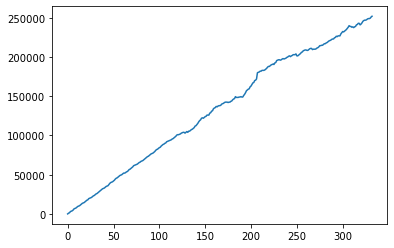

In [184]:
plt.plot(PnL_ll[[0, 1, 2] + list(range(4, 24)) + list(range(25, 308)) + list(range(309, 336))])

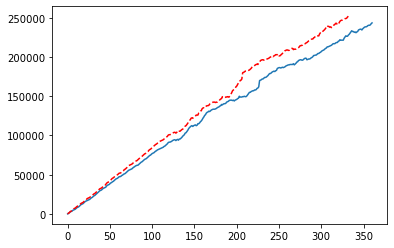

In [185]:
plt.plot(PnL_bench)
plt.plot(PnL_ll[[0, 1, 2] + list(range(4, 24)) + list(range(25, 308)) + list(range(309, 336))], color='red', linestyle='--')